## littleCNN: coding and using a deep learning tool for image classification

### Software setup

In [2]:
library(littleDeep)
library(jsonlite)

0/0 packages newly attached/loaded, see sessionInfo() for details.

1/0 packages newly attached/loaded, see sessionInfo() for details.



### Image data management

Acquisition:

In [3]:
if (!exists("cifdata")) cifdata = dataset_cifar100()

Exploration:  We'll see that the data are given in nested lists and that the labels are integers.

In [11]:
names(cifdata)

[1] "train" "test"

In [12]:
dim(cifdata[["train"]][["x"]])

[1] 50000    32    32     3

In [13]:
head(table(cifdata[["train"]][["y"]]))


  0   1   2   3   4   5 
500 500 500 500 500 500 

Decode the labels.  There are coarse- and fine-grained labels.

In [14]:
cifmeta = fromJSON(system.file("extdata", "cif.json", package="littleDeep"))
labs = cifmeta[[1]]$features$fine_label$names
head(labs)

[1] "apple"         "aquarium_fish" "baby"          "bear"         
[5] "beaver"        "bed"

Now map the textual labels to the images and wrap them in the ImageArray class container.  `ImageArray` is defined in littleDeep; other ways of organizing large collections of images may exist.

In [15]:
ciftrain = cifdata[[1]]$x
ciflabels = labs[cifdata[[1]]$y+1]

train = ImageArray(ciftrain, ciflabels)
train

ImageArray instance with 50000 images, each 32 x 32 x 3
 Image types: cattle dinosaur ... pickup_truck can 
 Array elements range from 0.000000 to 255.000000.

NULL

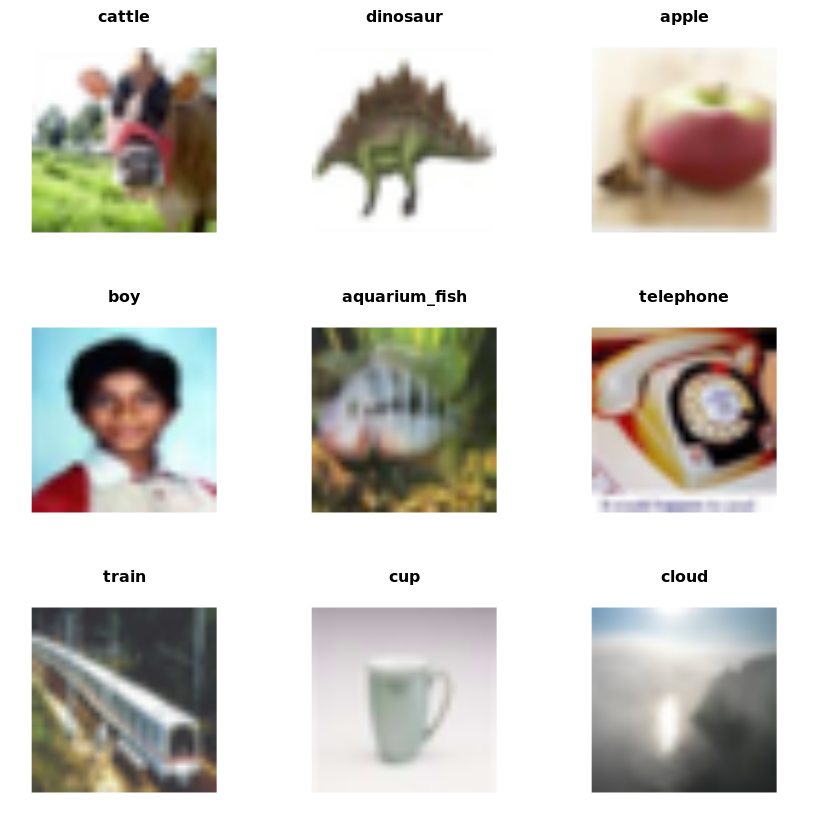

In [16]:
preview(train)

The same operations applied to the held out 'test' images.

In [17]:
ciftest = cifdata[["test"]]$x
ciftestlabs = labs[cifdata[["test"]]$y+1]
test = ImageArray(ciftest, ciftestlabs)
test

ImageArray instance with 10000 images, each 32 x 32 x 3
 Image types: mountain forest ... bear tiger 
 Array elements range from 0.000000 to 255.000000.

In [18]:
head(table(ciftestlabs))

ciftestlabs
        apple aquarium_fish          baby          bear        beaver 
          100           100           100           100           100 
          bed 
          100 

### Filtering images to specific classes

We will apply the simple CNN described in the workspace dashboard to images
of boys, chairs and roses.  littleDeep has a special function for this purpose.

In [19]:
littrain = filterByType(train, c("boy", "rose", "chair"))
littest = filterByType(test, c("boy", "rose", "chair"))
littrain

ImageArray instance with 1500 images, each 32 x 32 x 3
 Image types: boy rose chair 
 Array elements range from 0.000000 to 255.000000.

NULL

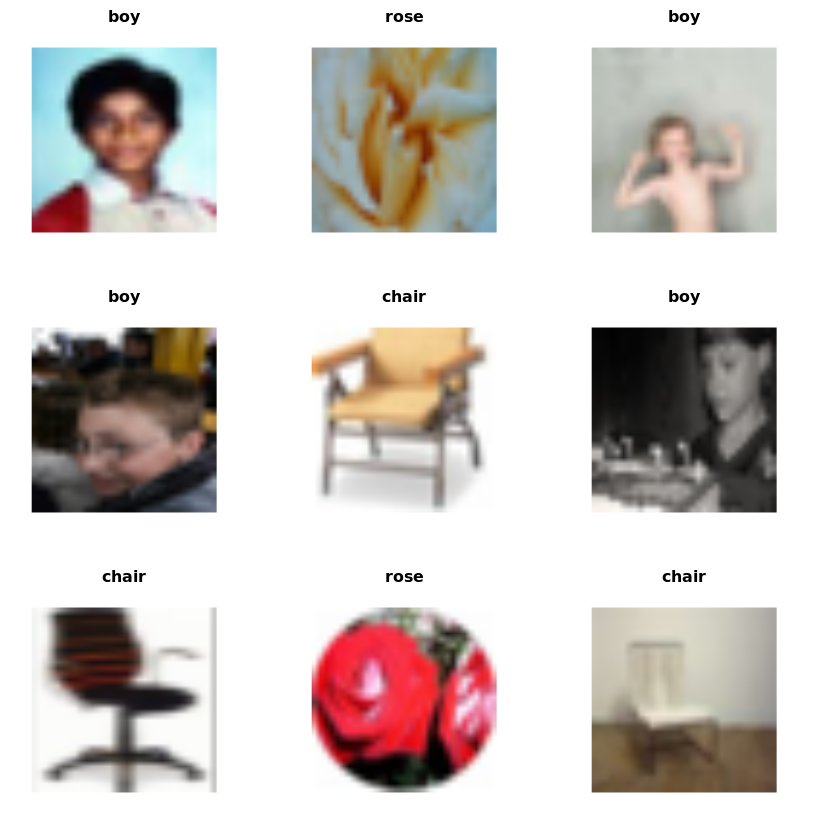

In [38]:
preview(littrain)

### Fitting the CNN

The custom function `islr_cnn` will estimate a million or so parameters to maximize a regularized version of the multinomial likelhood measuring the accuracy of predictions.  See expressions 10.14 and 10.31 of the ISLR book for formalisms.

In [20]:
args(islr_cnn)

function (iarr, nEpochs = 30, batchSize = 128, valSplit = 0.2) 
NULL

Notice the tuning parameters.  We will take the defaults except we use 50 epochs of training.

In [27]:
tr1 = islr_cnn(littrain, nEpochs=50)
tr1

littleDeep 0.0.32 ISLR CNN instance.
 the call was:
    islr_cnn(iarr = littrain, nEpochs = 50)
 use $model to retrieve model, $history, and model_probs() for prediction.

### Assessments

We visualize the accuracy (estimated with internal subsampling) over epochs:

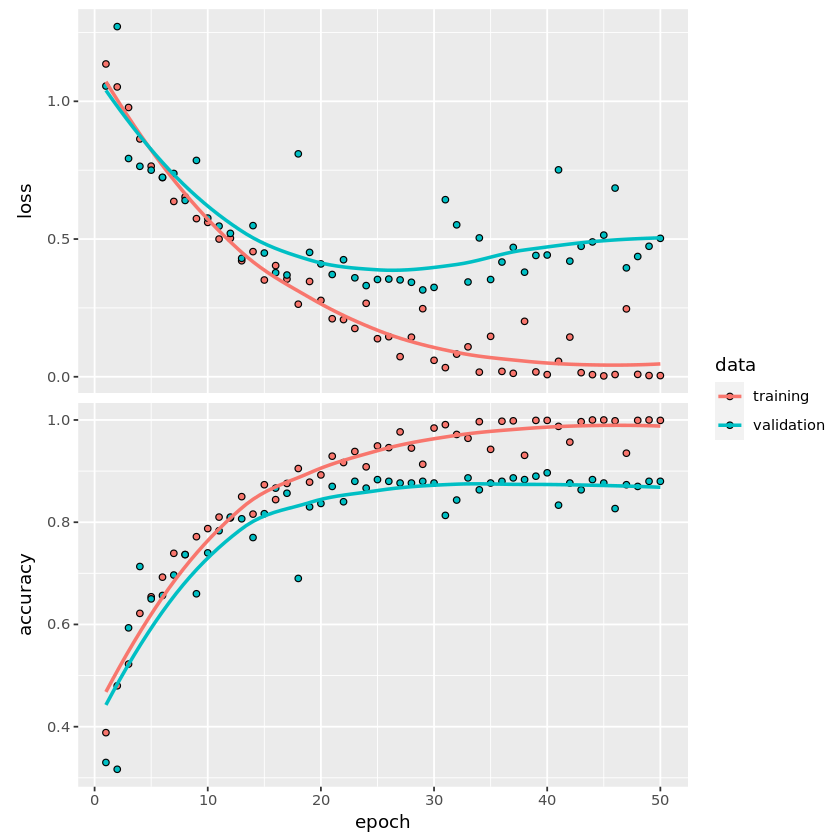

In [33]:
plot(tr1$history)

Validation accuracy seems to be a little more than 85%.  Let's compute prediction
accuracies over the held-out test set of images.  The `model_probs` function computes the class probabilities for each image in an ImageArray.

In [32]:
model_probs(tr1$model, littest[1:9])

boy,chair,rose
<dbl>,<dbl>,<dbl>
0,0,1
0,0,1
1,0,0
0,1,0
1,0,0
0,1,0
0,1,0
0,1,0
0,0,1


We'll use this to compute a confusion matrix.

In [36]:
confmat = function(trained_model, arr) {
 stopifnot(inherits(trained_model, "islr_cnn"))
 mp = model_probs(trained_model$model, arr)
 pred = trained_model$typelevels[ apply( data.matrix(mp),
   1, which.max) ]
 given = arr@types
 table(given=given, pred=pred)
}


In [37]:
confmat(tr1, littest)

       pred
given   boy chair rose
  boy    83    12    5
  chair   5    92    3
  rose   11     4   85

### Saving and restoring a fitted CNN

If we feel our model is well-trained and can be used for new images, we can save it.  The serialization is specific to keras.


In [40]:
tm = tempfile()
mpath = save_islr_cnn(tr1, tm)
library(rhdf5)
h5ls(mpath)

1/2 packages newly attached/loaded, see sessionInfo() for details.



,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,model_weights,H5I_GROUP,,
1,/model_weights,conv2d_10,H5I_GROUP,,
2,/model_weights/conv2d_10,conv2d_10,H5I_GROUP,,
3,/model_weights/conv2d_10/conv2d_10,bias:0,H5I_DATASET,FLOAT,64
4,/model_weights/conv2d_10/conv2d_10,kernel:0,H5I_DATASET,FLOAT,64 x 32 x 3 x 3
5,/model_weights,conv2d_11,H5I_GROUP,,
6,/model_weights/conv2d_11,conv2d_11,H5I_GROUP,,
7,/model_weights/conv2d_11/conv2d_11,bias:0,H5I_DATASET,FLOAT,32
8,/model_weights/conv2d_11/conv2d_11,kernel:0,H5I_DATASET,FLOAT,32 x 3 x 3 x 3


In [46]:
dir(tm)

[1] "addons.rda" "model.h5"

In [44]:
ll = restore_islr_cnn(tm)

In [45]:
ll

littleDeep 0.0.32 ISLR CNN instance.
 the call was:
    islr_cnn(iarr = littrain, nEpochs = 50)
 use $model to retrieve model, $history, and model_probs() for prediction.

In [47]:
ll$model

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_11 (Conv2D)                 (None, 32, 32, 32)              896         
 max_pooling2d_11 (MaxPooling2D)    (None, 16, 16, 32)              0           
 conv2d_10 (Conv2D)                 (None, 16, 16, 64)              18496       
 max_pooling2d_10 (MaxPooling2D)    (None, 8, 8, 64)                0           
 conv2d_9 (Conv2D)                  (None, 8, 8, 128)               73856       
 max_pooling2d_9 (MaxPooling2D)     (None, 4, 4, 128)               0           
 conv2d_8 (Conv2D)                  (None, 4, 4, 256)               295168      
 max_pooling2d_8 (MaxPooling2D)     (None, 2, 2, 256)               0           
 flatten_2 (Flatten)                (None, 1024)                    0           
 dropout_2 (Dropout)                (None, 1024)                    0           
 dense

### Conclusions

We've used the CIFAR100 images and a small chunk of code from ISLR in the following steps

- create a systematic, self-describing storage and labeling scheme for 32x32x3 jpeg images (ImageArray class)
- wrap the keras CNN model in a function that controls aspects of the fitting process and systematizes the output
- fit the CNN to training data and assess its performance with internal subsampling
- assess the CNN on independent data, producing a confusion matrix
- serialize and deserialize the fitted CNN

We conjecture that "explainable AI" would be pursued by exploring the arrays of weights in the HDF5 dataset displayed above.  Users should be able to employ the code in this notebook to explore which of the 100 image types in CIFAR100 are most resistant to accurate classification.
